In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import sys
sys.path.append("../scripts")

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
plt.rcParams["figure.figsize"] = (14,6)

In [51]:
obs = pd.read_hdf("../data/ts-covid.hdf", key="Argentina")
obs

,C,D,I,R
date,,,,
2020-01-28,0,0,0,0
2020-01-29,0,0,0,0
2020-01-30,0,0,0,0
2020-01-31,0,0,0,0
2020-02-01,0,0,0,0
...,...,...,...,...
2020-06-05,18471,573,12279,5618
2020-06-06,19301,590,12892,5817
2020-06-07,20150,608,13499,6042


In [52]:
obs = obs[["I", "R", "D"]]
obs = obs["2020-03-07":]
obs

,I,R,D
date,,,
2020-03-07,1,0,0
2020-03-08,3,0,0
2020-03-09,5,0,0
2020-03-10,7,0,0
2020-03-11,9,0,0
...,...,...,...
2020-06-05,12279,5618,573
2020-06-06,12892,5817,590
2020-06-07,13499,6042,608


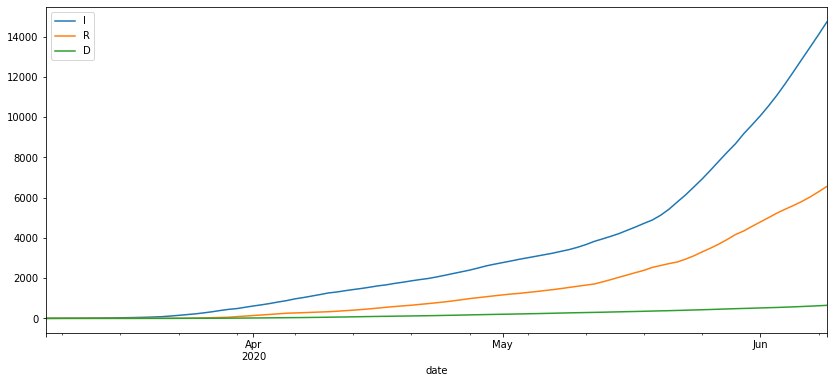

In [53]:
obs.plot()

In [54]:
def train_test_split(data, split, start=None, end=None):
    if start is None:
        start = data.index[0]
    if end is None:
        end = data.index[-1]
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    split = pd.to_datetime(split)
    one = pd.DateOffset(days=1)
    train = data[start:split-one].copy()
    test = data[split:end].copy()
    return train, test

In [55]:
data_start = "2020-04-01"
data_split = "2020-06-01"
train, test = train_test_split(obs, split=data_split, start=data_start)

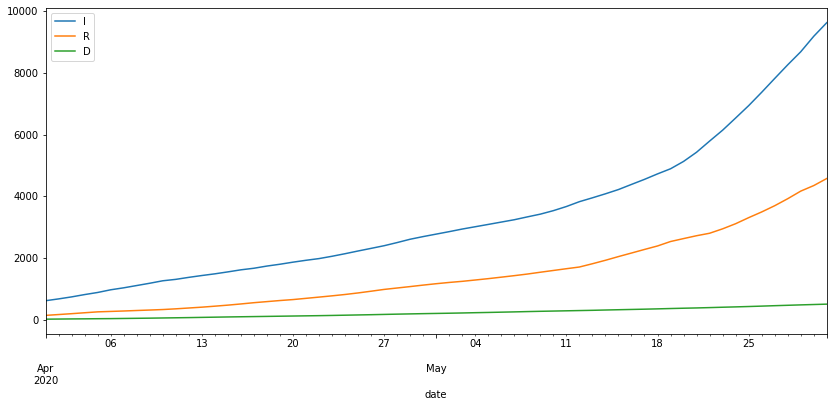

In [56]:
train.plot()

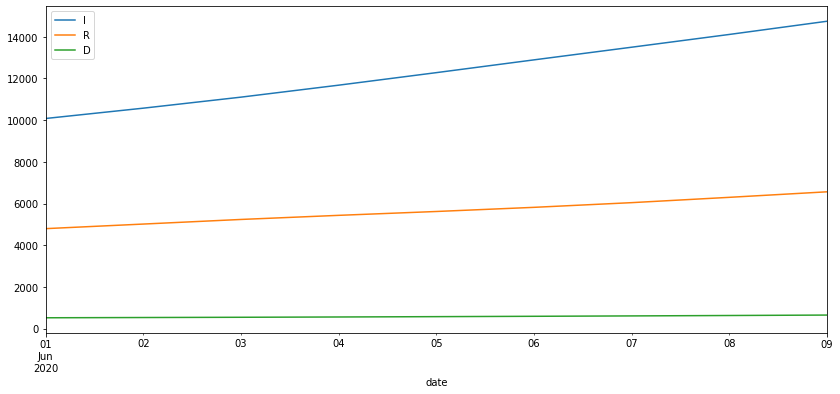

In [57]:
test.plot()

## SIR

In [58]:
from SEIR import SIR

In [59]:
init_I, init_R, init_D = train.iloc[0, :]

In [60]:
model = SIR(population=1e4, init_infected=init_I, init_recovered=init_R, init_dead=init_D)

In [61]:
model.fit(train, estimate=('r_transmission', "r_recovery", "r_mortality", "population"), 
          method="Nelder-Mead", options={"maxiter": 1000})

 final_simplex: (array([[7.09155921e-02, 2.27341691e-02, 3.10110996e-03, 3.07196017e+15],
       [7.09155921e-02, 2.27341691e-02, 3.10110996e-03, 3.07196017e+15],
       [7.09155921e-02, 2.27341691e-02, 3.10110996e-03, 3.07196017e+15],
       [7.09155921e-02, 2.27341691e-02, 3.10110996e-03, 3.07196017e+15],
       [7.09155921e-02, 2.27341691e-02, 3.10110996e-03, 3.07196017e+15]]), array([6551451.95228133, 6551451.95228133, 6551451.95228133,
       6551451.95228146, 6551451.95228146]))
           fun: 6551451.952281328
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 2097
           nit: 1000
        status: 2
       success: False
             x: array([7.09155921e-02, 2.27341691e-02, 3.10110996e-03, 3.07196017e+15])

In [62]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

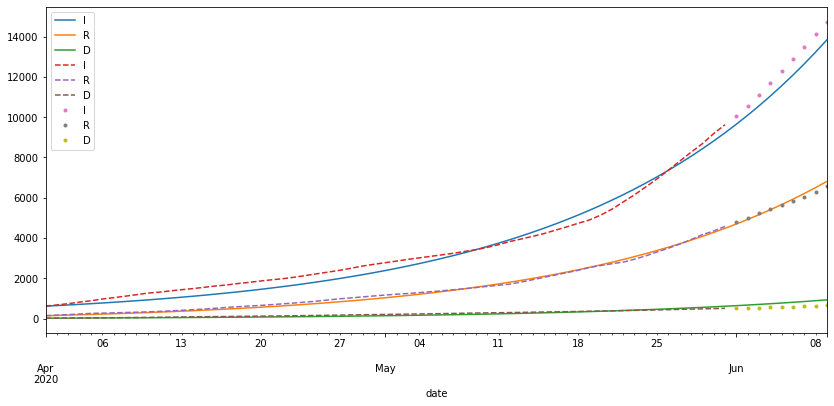

In [63]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIR

In [64]:
from SEIR import SEIR

In [65]:
model = SEIR(population=44e6, init_infected=init_I, init_recovered=init_R, init_dead=init_D, init_exposed=1000)

In [66]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_recovery", "r_mortality", "init_exposed"),
          method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[6.93613384e-02, 2.14069578e-02, 7.79254476e-01, 2.93187454e-03,
        1.94466772e+02],
       [6.93613357e-02, 2.14069569e-02, 7.79254369e-01, 2.93187309e-03,
        1.94466827e+02],
       [6.93613364e-02, 2.14069565e-02, 7.79254521e-01, 2.93187242e-03,
        1.94466726e+02],
       [6.93613396e-02, 2.14069579e-02, 7.79254634e-01, 2.93187388e-03,
        1.94466673e+02],
       [6.93613373e-02, 2.14069579e-02, 7.79254469e-01, 2.93187262e-03,
        1.94466766e+02],
       [6.93613392e-02, 2.14069581e-02, 7.79254518e-01, 2.93187429e-03,
        1.94466733e+02]]), array([5077433.6156238 , 5077433.61562525, 5077433.61562643,
       5077433.61562696, 5077433.61562955, 5077433.61563268]))
           fun: 5077433.615623797
       message: 'Optimization terminated successfully.'
          nfev: 4587
           nit: 2903
        status: 0
       success: True
             x: array([6.93613384e-02, 2.14069578e-02, 7.79254476e-01, 2.93187454e-03,
       1.94466772

In [67]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

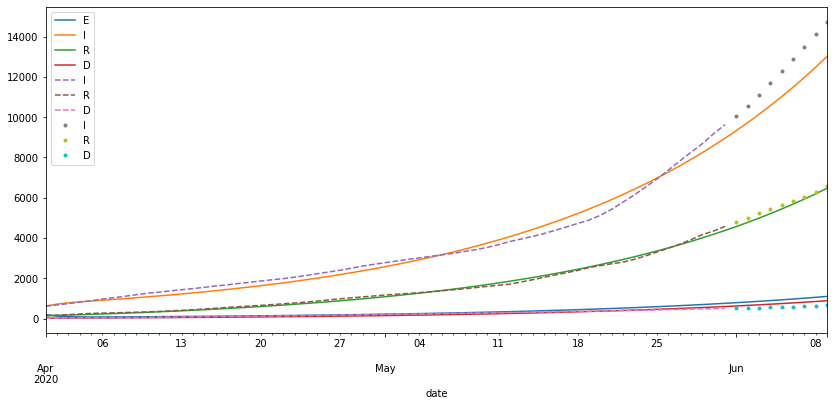

In [68]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIRH

In [69]:
from SEIR import SEIRH

In [70]:
model = SEIRH(init_infected=init_I, init_recovered=init_R, init_dead=init_D, 
              init_exposed=1000, init_hospitalized=100,
              r_hospitalized=0.05, r_recovery_hosp=0.01, r_recovery_mild=0.1)

In [71]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_mortality", 
                           "r_hospitalized", "r_recovery_hosp", "r_recovery_mild"), 
          method="Nelder-Mead", options={"maxiter": 10000})

 final_simplex: (array([[ 1.62527678e-01,  2.16050439e-02,  3.19018082e-03,
         1.05110974e-01, -1.45659188e-04,  5.34331505e-02],
       [ 1.62526866e-01,  2.16048760e-02,  3.19020742e-03,
         1.05111020e-01, -1.45490257e-04,  5.34328174e-02],
       [ 1.62527292e-01,  2.16049515e-02,  3.19017728e-03,
         1.05110997e-01, -1.45568171e-04,  5.34330120e-02],
       [ 1.62527050e-01,  2.16049043e-02,  3.19021293e-03,
         1.05111014e-01, -1.45532646e-04,  5.34329129e-02],
       [ 1.62527131e-01,  2.16048734e-02,  3.19018589e-03,
         1.05110971e-01, -1.45496106e-04,  5.34329675e-02],
       [ 1.62527140e-01,  2.16048233e-02,  3.19019285e-03,
         1.05110864e-01, -1.45421443e-04,  5.34329938e-02],
       [ 1.62527404e-01,  2.16048544e-02,  3.19018967e-03,
         1.05110866e-01, -1.45475576e-04,  5.34331156e-02]]), array([5310135.94491613, 5310135.94493139, 5310135.94497023,
       5310135.94497147, 5310135.94497199, 5310135.9449738 ,
       5310135.94501121]))

In [72]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

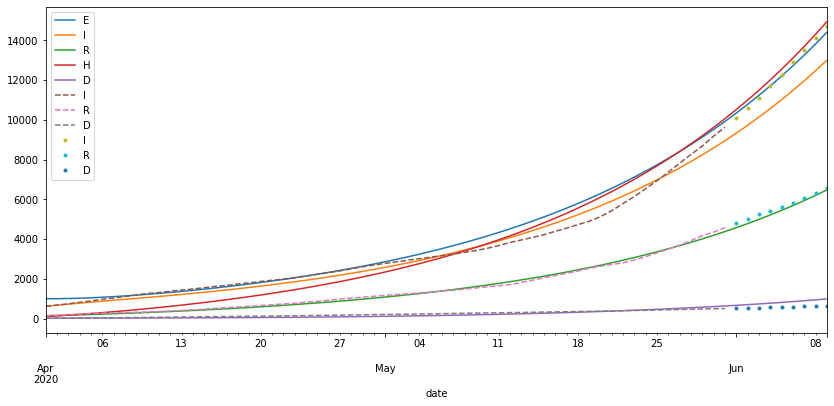

In [73]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")